# Introduction

The notebook is intended to perform a first Exploratory Data Analysis for a Binary Classification problem over the feature 'class'.

In [24]:
# Import Standard Modules
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score

import plotly.express as ex

import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import mlflow

In [25]:
# Notebook configurations
hyperparameters_tuning_method = 'Bayesian'

# Read Data

In [26]:
# Define start and end years
start_year = 2014
end_year = 2016

# Define range year
range_year = np.arange(start_year, end_year + 1, 1, dtype=np.int32)

In [27]:
# Init empty DataFrame
data = pd.DataFrame()

for year in range_year:

    year_data = pd.read_csv(f'./../data/{year}_Financial_Data.csv', 
                            sep=',', 
                            encoding='latin1', 
                            index_col=0)

    data = pd.concat([data, year_data])

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12725 entries, PG to WTT
Columns: 226 entries, Revenue to 2017 PRICE VAR [%]
dtypes: float64(224), int64(1), object(1)
memory usage: 22.0+ MB


In [29]:
data.head(5)

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%]
PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,1.449400e+10,...,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0,NaN,NaN
VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,...,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0,NaN,NaN
KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,2.270000e+09,...,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1,NaN,NaN
RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,2.502180e+08,...,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1,NaN,NaN
GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,2.707700e+09,...,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1,NaN,NaN


# Data Pre-processing

In [30]:
# Define label
y = data['Class']

# Define featuers
# NOTE: Drop '2015 PRICE VAR [%]' because it is directly related to the Class and it is only valid a posteriori
X = data.drop(['Class', 'Sector', '2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]'], axis=1)

## Check Data Distribution

In [31]:
# Check X feature distribution
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Revenue,12125.0,5.204594e+09,3.535010e+10,-6.276160e+08,5.581000e+07,4.150780e+08,2.226271e+09,1.886894e+12
Revenue Growth,11500.0,4.667105e+00,3.945140e+02,-1.276930e+01,-3.430000e-02,4.350000e-02,1.691000e-01,4.213866e+04
Cost of Revenue,11818.0,3.307229e+09,2.858291e+10,-2.665346e+09,2.865317e+06,1.422087e+08,1.155679e+09,1.581527e+12
Gross Profit,12116.0,1.957375e+09,9.354688e+09,-1.280800e+10,2.836850e+07,1.823530e+08,8.430000e+08,4.621600e+11
R&D Expenses,11611.0,9.706296e+07,6.864618e+08,-8.610000e+07,0.000000e+00,0.000000e+00,1.111300e+07,1.608500e+10
...,...,...,...,...,...,...,...,...
Asset Growth,11344.0,1.058469e+00,5.221703e+01,-1.000000e+00,-3.632500e-02,4.550000e-02,1.727250e-01,5.468426e+03
Book Value per Share Growth,11025.0,1.182940e+00,8.770679e+01,-3.963131e+03,-1.134000e-01,2.550000e-02,1.262000e-01,7.039326e+03
Debt Growth,11228.0,2.288833e+00,6.274580e+01,-1.051000e+00,-6.440000e-02,0.000000e+00,1.637000e-01,5.443000e+03
R&D Expense Growth,11355.0,3.377717e-01,1.501652e+01,-2.662200e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.542611e+03


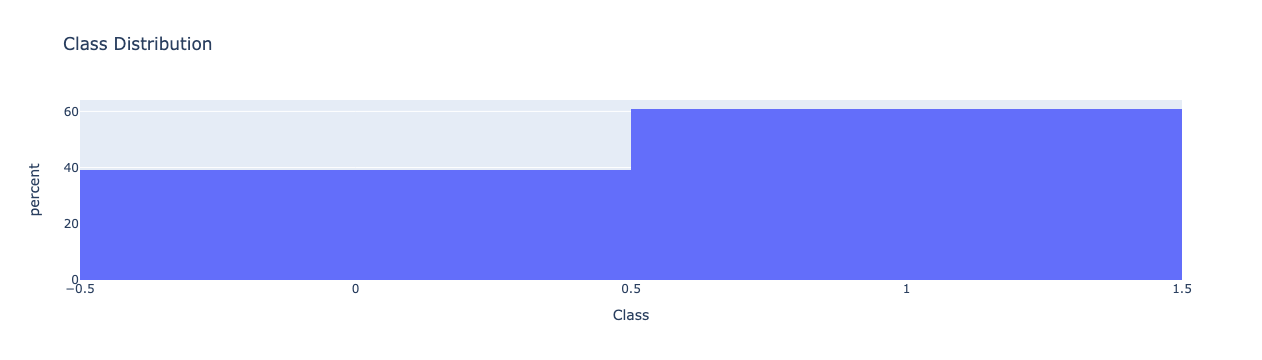

In [32]:
# Check 'Class' distribution
figure = ex.histogram(data_frame=y, 
                        x='Class', 
                        title='Class Distribution', 
                        histnorm='percent', 
                        nbins=len(np.unique(y.values)))
figure.show()

Quite well class distribution. No skewed classes.

In [33]:
# Check y for null values
len(y) - y.count()

0

## Fill NaN Values

In [34]:
# Fill NaN values with the mean
X = X.fillna(X.mean())

## Feature Normalization

In [35]:
# Instantiate MinMaxScaler
min_max_scaler = MinMaxScaler()

In [36]:
# Scale the data
X_scaled = pd.DataFrame(min_max_scaler.fit_transform(X.values), index=X.index, columns=X.columns)

# Feature Selection

## Univariate Selection

In [37]:
# Define the number of desired features
n_features = 180

In [38]:
# Fit the feature seletor
feature_selector = SelectKBest(score_func=chi2, k=n_features).fit(X_scaled, y)

In [39]:
# Extract the most important features
X_feature_selected = pd.DataFrame(feature_selector.transform(X_scaled), 
                                    index=X_scaled.index, 
                                    columns=feature_selector.get_feature_names_out())

# Exploratory Data Analysis

## Market Cap

In [40]:
# Plot the distribution of the market Cap
# TODO
#figure = ex.histogram(data_frame=X_feature_selected, 
#                        x='Market Cap', 
#                        title='Market Cap Distribution', 
#                        nbins=X_feature_selected['Market Cap'].nunique())
#figure.show()

# Split Data into Training and Test Sets

In [41]:
# Split data
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_feature_selected, y, test_size=test_size)

# Model Definition

## Hyperparameters Tuning

In [42]:
# Set initial space of hyperparameters
parameters = {
    'max_depth': np.arange(5, 10, 1),
    'min_child_weight': np.arange(5, 15, 1),
    'eta': np.linspace(0.01, 0.1, 10)
}

# Define the Hyperparamters space for Hyperopt
hyperopt_parameters_space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1, 9),
    'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'seed': 0
}

# Define the estimator for GridSearch and HalvingGridSearch
xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                       eval_metric='logloss',
                                       use_label_encoder=False)

### Grid Search

In [43]:
# Define GridSearch function
def grid_search():
    
    # Perform a Grid Search for hyperparameters tuning
    grid_search = GridSearchCV(estimator=xgboost_classifier, 
                               param_grid=parameters,
                               scoring='roc_auc',
                               n_jobs=2,
                               cv=2,
                               verbose=2)

    grid_search.fit(X_train, y_train)
    
    print(f"Grid Search best score: {grid_search.best_score_ * 100}")
    print(f"Grid Search best parameters: {grid_search.best_params_}")

    return grid_search.best_params_

### Halving Grid Search

In [44]:
# Define HalvingGridSearchCV function
def halving_grid_search():
    
    # Perform an Halving Grid Search for hyperparameters tuning
    halving_grid_search = HalvingGridSearchCV(estimator=xgboost_classifier, 
                                              param_grid=parameters, 
                                              scoring='roc_auc', 
                                              n_jobs=2, 
                                              cv=2, 
                                              verbose=2)
    
    halving_grid_search.fit(X_train, y_train)
    
    print(f"Halving Grid Search best score: {halving_grid_search.best_score_ * 100}")
    print(f"Halving  Search best parameters: {halving_grid_search.best_params_}")

    return halving_grid_search.best_params_

### Bayesian Optimization with HYPEROPT

In [45]:
# Define the Objective Function
def objective(space):
    
    # Create the estimator
    clf=xgb.XGBClassifier(n_estimators=space['n_estimators'], 
                          max_depth=int(space['max_depth']), 
                          gamma=space['gamma'],
                          reg_alpha=int(space['reg_alpha']),
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=int(space['colsample_bytree']),
                          use_label_encoder=False)
    
    # Define the validation set
    evaluation = [( X_test, y_test)]
    
    # Fit the estimator
    clf.fit(X_train, 
            y_train,
            eval_set=evaluation, 
            eval_metric="auc",
            early_stopping_rounds=10,
            verbose=False)
    
    # Evaluate the estimator with the test set
    pred = clf.predict(X_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, pred>0.5)
    
    print ("SCORE:", accuracy)
    
    return {'loss': -accuracy, 'status': STATUS_OK }

### Perform Hyperparameters Tuning

In [46]:
# Perform the Hyperparameters Tuning
# NOTE: switch based on the method
if hyperparameters_tuning_method == 'Bayesian':
    
    best_hyperparams = fmin(fn=objective,
                            space=hyperopt_parameters_space,
                            algo=tpe.suggest,
                            max_evals=100,
                            trials=Trials())
    
elif hyperparameters_tuning_method == 'Halving Grid Search':
    
    parameters = halving_grid_search()

SCORE:                                                                                                                                                                                                                     
0.6457142857142857                                                                                                                                                                                                         
SCORE:                                                                                                                                                                                                                     
0.6473809523809524                                                                                                                                                                                                         
SCORE:                                                                                                                  

## Training

In [ ]:
# Set Experiment Name
experiment_name = "US Stock Binary Classification - XGBoost"

In [ ]:
# Retrieve experiment
experiment = mlflow.get_experiment_by_name(experiment_name)

# Check if Experiment exists
if experiment is None:

    print('Creating MLFlow experiment')

    # Create experiment
    _ = mlflow.create_experiment(experiment_name)

    # Retrieve experiment
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [ ]:
# Start experiment
with mlflow.start_run(experiment_id=experiment.experiment_id):

    # Define hyperparameters (GridSearch)
    max_depth = parameters['max_depth']
    min_child_weight = parameters['min_child_weight']
    eta = parameters['eta']
    

    # Create and fit the model
    model = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric='logloss',
                              eta=eta,
                              max_depth=max_depth,
                              min_child_weight=min_child_weight,
                              use_label_encoder=False)

    # Model Training
    model.fit(X_train, y_train)

    # Model Evaluation
    logloss_training = round(model.score(X_train, y_train), 2) * 100
    logloss_test = round(model.score(X_test, y_test), 2) * 100

    # Log MLFlow
    mlflow.log_param('start_year', start_year)
    mlflow.log_param('end_year', end_year)
    mlflow.log_param('data_dimension', len(data))
    mlflow.log_param('hyperparameters_tuning_method', hyperparameters_tuning_method)
    mlflow.log_param('n_features', n_features)
    mlflow.log_metric('training_score', logloss_training)
    mlflow.log_metric('test_score', logloss_test)

## Model Evaluation

In [ ]:
# Model Score
print('Model score on the training set: {:.2f}'.format(logloss_training))
print('Model score on the test set: {:.2f}'.format(logloss_test))

In [ ]:
# Retrieve MLFlow Runs
mlflow.search_runs(experiment_ids=experiment.experiment_id)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f1efe245-29af-4be1-bb79-055f4abb0e16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>